In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, concat
from google.colab import drive
drive.mount('/content/drive')
from datetime import date
import time
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import math
from math import radians
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras import layers
from keras.models import Model

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.backend import mean, maximum

In [3]:
#### 파라미터 ####

# 하루의 틱
ticks = 48

# 예측에 사용할 일수
days = 3                # 이 부분을 바꿀 수 있다.
n_days = ticks*days

# 미래 예측할 일수
future_days = 2
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']

# 사용할 변수
what_to_left = ['Time', 'WS', 'DHI','DNI','RH','T','TARGET', 'Day']

n_features = len(what_to_left)
n_obs = n_days * n_features # 7일 예측 기준으로 7(일 수) * 48(틱 수) * 6(변수 개수)

In [4]:
# 데이터 불러오기 

raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/sample_submission.csv')
submission.shape

(7776, 10)

In [5]:
def drop_clms(dataset):
  dataset['Time'] = dataset['Hour'] + dataset['Minute']*(0.5/30)
  dataset['Date'] = dataset['Day']%365
  dataset.drop('Day', axis=1, inplace=True)
  
  temp = list()
  for i in range(0, len(dataset), 48):
    temp += [24-(list(dataset.DHI[i:i+48]).count(0)*0.5)]*48 

  dataset["SH"] = temp

  return dataset

def cos_time(dataset):
  dataset['sin_time'] = np.sin(2*np.pi*dataset.Time/24)
  dataset['cos_time'] = np.cos(2*np.pi*dataset.Time/24)
  return dataset

In [6]:
def get_yday(when):
  HP = date(2020,1,1)
  results = (when-HP).days
  return results

In [7]:
def 절기24(Date):
  target = 0
  for i in list24:
    if Date < i:
      target = list24.index(i) - 1
      break
  if Date < 5:
    target = 23
  return target

In [8]:
# 머신러닝에 쓰기 위해서 재정렬 시키는 series_to_supervised 함수

def train_to_supervised(train, target, n_in):

    clmns = list(train.columns)

    # 기타 칼럼은 전과 같이 들어갈 것.
    scaled_lst = clmns

    scaled_df = train[scaled_lst]
    target_df = target

    # 미래 몇 번째 항목을 가져올 것인가
    future = [48, 96]

    ### 만약에 스케일링을 하고 싶다면 ###
    # scaled_df 데이터 프레임만 스케일링 하고, 절기랑 TARGET 데이터는 그냥 두면 된다.

    # 스케일링 해도 되고, 안해도 되는 기존에 썻던 변수들 전처리
    cols, names = list(), list()
    n_vars = 1 if type(scaled_df) is list else scaled_df.shape[1]
    n_vars2 = 1 if type(target_df) is list else target_df.shape[1]
    for i in range(n_in, 0, -1):
        cols.append(scaled_df.shift(i))
        names += ['%s(t-%d)' % (j, i) for j in scaled_df.columns]

    # 48과 96 후의 타겟 데이터 2개 붙이기.
    # forecast sequence (t, t+1, ... t+n)
    for i in future:
        cols.append(target_df.shift(-i))
        if i == 0:
            names += [('TARGET%d(t)' % (j+1)) for j in range(n_vars2)]
        else:
            names += [('TARGET%d(t+%d)' % (j+1, i)) for j in range(n_vars2)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg

In [9]:
# 머신러닝에 쓰기 위해서 재정렬 시키는 series_to_supervised 함수

def test_to_supervised(train, n_in):

    clmns = list(train.columns)

    # 타켓 칼럼의 이름을 여기에 입력
    target = ['TARGET']

    # 클래스 변수로 전환(encoding)할 칼럼을 여기에 입력
#    class_lst = ['season']

    # 기타 칼럼은 전과 같이 들어갈 것.
#    scaled_lst = list(set(clmns) - set(class_lst))

    scaled_df = train.copy()
#    class_df = train[class_lst]

    ### 만약에 스케일링을 하고 싶다면 ###
    # testset의 스케일링은 구조가 상당히 까다로우므로....... 일단 나중에 하기로 함.

    # 스케일링 해도 되고, 안해도 되는 기존에 썻던 변수들 전처리
    cols, names = list(), list()
    n_vars = 1 if type(scaled_df) is list else scaled_df.shape[1]
    for i in range(n_in, 0, -1):
        cols.append(scaled_df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in scaled_df.columns]

    # class라 encoding 필요한 절기 끝에 하나만 붙여놓기
#    cols.append(class_df)
#    names += class_lst
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg

In [33]:
def add_variables(dataset):
  sunny = list()
  avg_temp = list()
  max_temp = list()
  min_temp = list()
  avg_ghi = list()
  max_ghi = list()
  min_ghi = list()
  avg_tar = list()
  max_tar = list()
  min_tar = list()


  for i in range(0, len(dataset), 48):
    temp = dataset['Temp'][i:i+48]
    ghi = dataset['GHIs'][i:i+48]
    tar = dataset['TARGET'][i:i+48]
    sunny += [24-(list(dataset.DHI[i:i+48]).count(0)*0.5)]*48 
    avg_temp += [temp.mean()]*48
    max_temp += [temp.max()]*48
    min_temp += [temp.min()]*48
    avg_ghi += [ghi.sum()/(24-(list(dataset.DHI[i:i+48]).count(0)*0.5))]*48
    max_ghi += [ghi.max()]*48
    min_ghi += [ghi[ghi>0.01].min()]*48
    avg_tar += [tar.sum()/(24-(list(dataset.DHI[i:i+48]).count(0)*0.5))]*48
    max_tar += [tar.max()]*48
    min_tar += [tar[tar>0.01].min()]*48


  dataset["SH"] = sunny
  dataset["Avg_temp"] = avg_temp
  dataset['Max_temp'] = max_temp
  dataset['Min_temp'] = min_temp
  dataset["Avg_GHI"] = avg_ghi
  dataset['Max_GHI'] = max_ghi
  dataset['Min_GHI'] = min_ghi
  dataset["Avg_TAR"] = avg_tar
  dataset['Max_TAR'] = max_tar
  dataset['Min_TAR'] = min_tar
  
  return dataset

In [10]:
소한 = get_yday(date(2020,1,6))
대한 = get_yday(date(2020,1,20))
입춘 = get_yday(date(2020,2,4))
우수 = get_yday(date(2020,2,19))
경칩 = get_yday(date(2020,3,6))
춘분 = get_yday(date(2020,3,21))
청명 = get_yday(date(2020,4,5))
곡우 = get_yday(date(2020,4,20))
입하 = get_yday(date(2020,5,6))
소만 = get_yday(date(2020,5,21))
망종 = get_yday(date(2020,6,6))
하지 = get_yday(date(2020,6,22))
소서 = get_yday(date(2020,7,7))
대서 = get_yday(date(2020,7,23))
입추 = get_yday(date(2020,8,8))
처서 = get_yday(date(2020,8,23))
백로 = get_yday(date(2020,9,8))
추분 = get_yday(date(2020,9,23))
한로 = get_yday(date(2020,10,8))
상강 = get_yday(date(2020,10,24))
입동 = get_yday(date(2020,11,8))
소설 = get_yday(date(2020,11,22))
대설 = get_yday(date(2020,12,7))
동지 = get_yday(date(2020,12,22))

list24 = [소한, 대한, 입춘, 우수, 경칩, 춘분, 청명, 곡우, 입하, 소만, 망종, 하지, 소서, 대서, 입추, 처서, 백로, 추분, 한로, 상강, 입동, 소설, 대설, 동지]

In [11]:
m = 60

일출 = [7+47/m, 7+44/m, 7+34/m, 7+18/m, 6+56/m, 6+35/m, 6+12/m, 5+51/m, 5+33/m, 5+19/m, 5+11/m, 5+11/m, 5+17/m, 5+27/m, 5+41/m, 5+54/m, 6+8/m, 6+20/m, 6+33/m, 6+47/m, 7+3/m, 7+20/m, 7+33/m, 7+45/m]
일몰 = [17+28/m, 17+42/m, 17+58/m, 18+15/m, 18+30/m, 18+44/m, 18+58/m, 19+12/m, 19+25/m, 19+39/m, 19+50/m, 19+57/m, 19+56/m, 19+50/m, 19+35/m, 19+15/m, 18+51/m, 18+28/m, 18+6/m, 17+45/m, 17+28/m, 17+17/m, 17+13/m, 17+17/m]
경사각 = [32.92, 36.83, 40.75, 44.67, 48.58, 52.5, 56.42, 60.33, 64.25, 68.16, 72.01, 76, 72.1, 68.16, 64.25, 60.33, 56.42, 52.5, 48.58, 44.67, 40.75, 36.83, 32.92, 29]
남중 = [12+36/m, 12+41/m, 12+44/m, 12+44/m, 12+42/m, 12+38/m, 12+34/m, 12+29/m, 12+27/m, 12+27/m, 12+29/m, 12+32/m, 12+35/m, 12+37/m, 12+36/m, 12+33/m, 12+29/m, 12+23/m, 12+18/m, 12+15/m, 12+14/m, 12+16/m, 12+22/m, 12+29/m]
print(len(일출), len(일몰), len(경사각), len(남중))

24 24 24 24


In [12]:
def HRA(DHI, DNI, season, hour):
  # 위도(latitude) 기준을 일단 임의로 대전으로 설정 (위도 36.19~36.2도)
  latitude = radians(36.2)
  season = int(season)
  # 절기별 대한민국의 경사각
  tilt = radians(경사각[season])

  # 절기별 대한민국 대전의 태양 남중시각
  hra = radians(15*(hour - 남중[season]))

  # 구하려는 알파
  elevation = np.arcsin(np.sin(tilt) * np.sin(latitude) + np.cos(tilt) * np.cos(latitude) * np.cos(hra))

  # 천정각(Zenith Angle)은 90 - 알파
  zenith = radians(90) - elevation

  # GHI는 DHI + DNI * cos(천정각)
  ghi = DHI + DNI *np.cos(zenith)

  return ghi

In [13]:
def not_minus(dataset):
  for i in range(0, len(dataset.index)):
    for j in range(0, len(dataset.columns)):
      K = dataset.iloc[i,j]
      if K < 0.09:
        dataset.iloc[i,j] = 0
  return dataset

In [14]:
dataset = raw_data.copy()
dataset2 = drop_clms(dataset)
dataset2.drop(['Hour', 'Minute'], axis =1, inplace=True)
dataset2.rename(columns = {'T' : 'Temp'}, inplace = True)
dataset2

,DHI,DNI,WS,RH,Temp,TARGET,Time,Date,SH
0,0,0,1.5,69.08,-12,0.0,0.0,0,9.0
1,0,0,1.5,69.06,-12,0.0,0.5,0,9.0
2,0,0,1.6,71.78,-12,0.0,1.0,0,9.0
3,0,0,1.6,71.75,-12,0.0,1.5,0,9.0
4,0,0,1.6,75.20,-12,0.0,2.0,0,9.0
...,...,...,...,...,...,...,...,...,...
52555,0,0,2.4,70.70,-4,0.0,21.5,364,9.0
52556,0,0,2.4,66.79,-4,0.0,22.0,364,9.0
52557,0,0,2.2,66.78,-4,0.0,22.5,364,9.0
52558,0,0,2.1,67.72,-4,0.0,23.0,364,9.0


In [15]:
dataset2['season'] = dataset2.apply(lambda x: 절기24(x['Date']), axis = 1)
dataset3 = cos_time(dataset2)
dataset4 = dataset3[['DHI', 'DNI', 'WS', 'RH', 'Temp', 'TARGET', 'SH', 'sin_time', 'cos_time','season', 'Time']]
# dataset5 = dataset4.iloc[n_days:,:-1]
# goals = pd.DataFrame(dataset4.Goal, index = dataset4.index)
dataset4

,DHI,DNI,WS,RH,Temp,TARGET,SH,sin_time,cos_time,season,Time
0,0,0,1.5,69.08,-12,0.0,9.0,0.000000,1.000000,23,0.0
1,0,0,1.5,69.06,-12,0.0,9.0,0.130526,0.991445,23,0.5
2,0,0,1.6,71.78,-12,0.0,9.0,0.258819,0.965926,23,1.0
3,0,0,1.6,71.75,-12,0.0,9.0,0.382683,0.923880,23,1.5
4,0,0,1.6,75.20,-12,0.0,9.0,0.500000,0.866025,23,2.0
...,...,...,...,...,...,...,...,...,...,...,...
52555,0,0,2.4,70.70,-4,0.0,9.0,-0.608761,0.793353,0,21.5
52556,0,0,2.4,66.79,-4,0.0,9.0,-0.500000,0.866025,0,22.0
52557,0,0,2.2,66.78,-4,0.0,9.0,-0.382683,0.923880,0,22.5
52558,0,0,2.1,67.72,-4,0.0,9.0,-0.258819,0.965926,0,23.0


In [34]:
dataset5= dataset4.copy()

dataset5['GHIs'] = dataset4.apply(lambda x: HRA(x.DHI, x.DNI, x.season, x.Time), axis=1)

In [35]:
dataset5.iloc[50:51,:]

,DHI,DNI,WS,RH,Temp,TARGET,SH,sin_time,cos_time,season,Time,GHIs
50,0,0,1.6,88.11,-11,0.0,9.0,0.258819,0.965926,23,1.0,0.0


In [36]:
dataset6 = add_variables(dataset5)

In [41]:
dataset7 = dataset6[['RH', 'Temp','Avg_temp', 'Max_temp', 'Min_temp', 'Avg_GHI', 'Max_GHI','Min_GHI', 'SH', 'sin_time', 'cos_time', 'GHIs', 'Avg_TAR', 'Max_TAR', 'Min_TAR', 'TARGET']]
dataset7.head(10)

,RH,Temp,Avg_temp,Max_temp,Min_temp,Avg_GHI,Max_GHI,Min_GHI,SH,sin_time,cos_time,GHIs,Avg_TAR,Max_TAR,Min_TAR,TARGET
0,69.08,-12,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.000000,1.000000,0.0,34.777337,33.129393,0.938541,0.0
1,69.06,-12,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.130526,0.991445,0.0,34.777337,33.129393,0.938541,0.0
2,71.78,-12,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.258819,0.965926,0.0,34.777337,33.129393,0.938541,0.0
3,71.75,-12,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.382683,0.923880,0.0,34.777337,33.129393,0.938541,0.0
4,75.20,-12,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.500000,0.866025,0.0,34.777337,33.129393,0.938541,0.0
5,69.29,-11,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.608761,0.793353,0.0,34.777337,33.129393,0.938541,0.0
6,72.56,-11,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.707107,0.707107,0.0,34.777337,33.129393,0.938541,0.0
7,72.55,-11,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.793353,0.608761,0.0,34.777337,33.129393,0.938541,0.0
8,74.62,-11,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.866025,0.500000,0.0,34.777337,33.129393,0.938541,0.0
9,74.61,-11,-7.979167,-3,-12,578.031164,705.717934,10.0,9.0,0.923880,0.382683,0.0,34.777337,33.129393,0.938541,0.0


In [42]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(dataset7)
temp_X = pd.DataFrame(scaler.transform(dataset7), columns = dataset7.columns)
temp_y = pd.DataFrame(dataset7['TARGET'])

## dataset6 가지고 동일하게 to_supervised 함수를 써서 나누면 됩니다.
### 나머지 변수 합치기, 인코딩은 유진이가 해줄 것...

In [43]:
dataset8 = train_to_supervised(temp_X,temp_y, n_days)
dataset8

,RH(t-144),Temp(t-144),Avg_temp(t-144),Max_temp(t-144),Min_temp(t-144),Avg_GHI(t-144),Max_GHI(t-144),Min_GHI(t-144),SH(t-144),sin_time(t-144),cos_time(t-144),GHIs(t-144),Avg_TAR(t-144),Max_TAR(t-144),Min_TAR(t-144),TARGET(t-144),RH(t-143),Temp(t-143),Avg_temp(t-143),Max_temp(t-143),Min_temp(t-143),Avg_GHI(t-143),Max_GHI(t-143),Min_GHI(t-143),SH(t-143),sin_time(t-143),cos_time(t-143),GHIs(t-143),Avg_TAR(t-143),Max_TAR(t-143),Min_TAR(t-143),TARGET(t-143),RH(t-142),Temp(t-142),Avg_temp(t-142),Max_temp(t-142),Min_temp(t-142),Avg_GHI(t-142),Max_GHI(t-142),Min_GHI(t-142),...,cos_time(t-3),GHIs(t-3),Avg_TAR(t-3),Max_TAR(t-3),Min_TAR(t-3),TARGET(t-3),RH(t-2),Temp(t-2),Avg_temp(t-2),Max_temp(t-2),Min_temp(t-2),Avg_GHI(t-2),Max_GHI(t-2),Min_GHI(t-2),SH(t-2),sin_time(t-2),cos_time(t-2),GHIs(t-2),Avg_TAR(t-2),Max_TAR(t-2),Min_TAR(t-2),TARGET(t-2),RH(t-1),Temp(t-1),Avg_temp(t-1),Max_temp(t-1),Min_temp(t-1),Avg_GHI(t-1),Max_GHI(t-1),Min_GHI(t-1),SH(t-1),sin_time(t-1),cos_time(t-1),GHIs(t-1),Avg_TAR(t-1),Max_TAR(t-1),Min_TAR(t-1),TARGET(t-1),TARGET1(t+48),TARGET1(t+96)
144,0.665404,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.500000,1.000000,0.0,0.232124,0.254563,0.096779,0.0,0.665188,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.565263,0.995722,0.0,0.232124,0.254563,0.096779,0.0,0.694622,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,...,0.961940,0.0,0.071674,0.078569,0.075271,0.0,0.795368,0.111111,0.191123,0.239130,0.162162,0.100076,0.373454,0.018912,0.083333,0.370590,0.982963,0.0,0.071674,0.078569,0.075271,0.0,0.795260,0.111111,0.191123,0.239130,0.162162,0.100076,0.373454,0.018912,0.083333,0.434737,0.995722,0.0,0.071674,0.078569,0.075271,0.0,0.0,0.0
145,0.665188,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.565263,0.995722,0.0,0.232124,0.254563,0.096779,0.0,0.694622,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.629410,0.982963,0.0,0.232124,0.254563,0.096779,0.0,0.694297,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,...,0.982963,0.0,0.071674,0.078569,0.075271,0.0,0.795260,0.111111,0.191123,0.239130,0.162162,0.100076,0.373454,0.018912,0.083333,0.434737,0.995722,0.0,0.071674,0.078569,0.075271,0.0,0.759333,0.092593,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.500000,1.000000,0.0,0.198174,0.309021,0.032260,0.0,0.0,0.0
146,0.694622,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.629410,0.982963,0.0,0.232124,0.254563,0.096779,0.0,0.694297,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.691342,0.961940,0.0,0.232124,0.254563,0.096779,0.0,0.731631,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,...,0.995722,0.0,0.071674,0.078569,0.075271,0.0,0.759333,0.092593,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.500000,1.000000,0.0,0.198174,0.309021,0.032260,0.0,0.759442,0.111111,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.565263,0.995722,0.0,0.198174,0.309021,0.032260,0.0,0.0,0.0
147,0.694297,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.691342,0.961940,0.0,0.232124,0.254563,0.096779,0.0,0.731631,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.750000,0.933013,0.0,0.232124,0.254563,0.096779,0.0,0.667677,0.148148,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,...,1.000000,0.0,0.198174,0.309021,0.032260,0.0,0.759442,0.111111,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.565263,0.995722,0.0,0.198174,0.309021,0.032260,0.0,0.758576,0.111111,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.629410,0.982963,0.0,0.198174,0.309021,0.032260,0.0,0.0,0.0
148,0.731631,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.750000,0.933013,0.0,0.232124,0.254563,0.096779,0.0,0.667677,0.148148,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.804381,0.896677,0.0,0.232124,0.25456

In [44]:
X = dataset8.iloc[:,:-2]
#X = encoding(X)
#X.drop('season', axis =1, inplace=True)
y = pd.DataFrame(dataset8.iloc[:,-2:])
X

,RH(t-144),Temp(t-144),Avg_temp(t-144),Max_temp(t-144),Min_temp(t-144),Avg_GHI(t-144),Max_GHI(t-144),Min_GHI(t-144),SH(t-144),sin_time(t-144),cos_time(t-144),GHIs(t-144),Avg_TAR(t-144),Max_TAR(t-144),Min_TAR(t-144),TARGET(t-144),RH(t-143),Temp(t-143),Avg_temp(t-143),Max_temp(t-143),Min_temp(t-143),Avg_GHI(t-143),Max_GHI(t-143),Min_GHI(t-143),SH(t-143),sin_time(t-143),cos_time(t-143),GHIs(t-143),Avg_TAR(t-143),Max_TAR(t-143),Min_TAR(t-143),TARGET(t-143),RH(t-142),Temp(t-142),Avg_temp(t-142),Max_temp(t-142),Min_temp(t-142),Avg_GHI(t-142),Max_GHI(t-142),Min_GHI(t-142),...,SH(t-3),sin_time(t-3),cos_time(t-3),GHIs(t-3),Avg_TAR(t-3),Max_TAR(t-3),Min_TAR(t-3),TARGET(t-3),RH(t-2),Temp(t-2),Avg_temp(t-2),Max_temp(t-2),Min_temp(t-2),Avg_GHI(t-2),Max_GHI(t-2),Min_GHI(t-2),SH(t-2),sin_time(t-2),cos_time(t-2),GHIs(t-2),Avg_TAR(t-2),Max_TAR(t-2),Min_TAR(t-2),TARGET(t-2),RH(t-1),Temp(t-1),Avg_temp(t-1),Max_temp(t-1),Min_temp(t-1),Avg_GHI(t-1),Max_GHI(t-1),Min_GHI(t-1),SH(t-1),sin_time(t-1),cos_time(t-1),GHIs(t-1),Avg_TAR(t-1),Max_TAR(t-1),Min_TAR(t-1),TARGET(t-1)
144,0.665404,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.500000,1.000000,0.0,0.232124,0.254563,0.096779,0.0,0.665188,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.565263,0.995722,0.0,0.232124,0.254563,0.096779,0.0,0.694622,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,...,0.083333,0.308658,0.961940,0.0,0.071674,0.078569,0.075271,0.0,0.795368,0.111111,0.191123,0.239130,0.162162,0.100076,0.373454,0.018912,0.083333,0.370590,0.982963,0.0,0.071674,0.078569,0.075271,0.0,0.795260,0.111111,0.191123,0.239130,0.162162,0.100076,0.373454,0.018912,0.083333,0.434737,0.995722,0.0,0.071674,0.078569,0.075271,0.0
145,0.665188,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.565263,0.995722,0.0,0.232124,0.254563,0.096779,0.0,0.694622,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.629410,0.982963,0.0,0.232124,0.254563,0.096779,0.0,0.694297,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,...,0.083333,0.370590,0.982963,0.0,0.071674,0.078569,0.075271,0.0,0.795260,0.111111,0.191123,0.239130,0.162162,0.100076,0.373454,0.018912,0.083333,0.434737,0.995722,0.0,0.071674,0.078569,0.075271,0.0,0.759333,0.092593,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.500000,1.000000,0.0,0.198174,0.309021,0.032260,0.0
146,0.694622,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.629410,0.982963,0.0,0.232124,0.254563,0.096779,0.0,0.694297,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.691342,0.961940,0.0,0.232124,0.254563,0.096779,0.0,0.731631,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,...,0.083333,0.434737,0.995722,0.0,0.071674,0.078569,0.075271,0.0,0.759333,0.092593,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.500000,1.000000,0.0,0.198174,0.309021,0.032260,0.0,0.759442,0.111111,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.565263,0.995722,0.0,0.198174,0.309021,0.032260,0.0
147,0.694297,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.691342,0.961940,0.0,0.232124,0.254563,0.096779,0.0,0.731631,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.750000,0.933013,0.0,0.232124,0.254563,0.096779,0.0,0.667677,0.148148,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,...,0.083333,0.500000,1.000000,0.0,0.198174,0.309021,0.032260,0.0,0.759442,0.111111,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.565263,0.995722,0.0,0.198174,0.309021,0.032260,0.0,0.758576,0.111111,0.210966,0.260870,0.135135,0.262510,0.790891,0.008105,0.083333,0.629410,0.982963,0.0,0.198174,0.309021,0.032260,0.0
148,0.731631,0.129630,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.750000,0.933013,0.0,0.232124,0.254563,0.096779,0.0,0.667677,0.148148,0.153525,0.173913,0.189189,0.299808,0.585426,0.024316,0.083333,0.80

In [45]:
X_train, X_valid, Y_train,  Y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

# testset은 이미 24절기(season)가 들어있으므로, 약간 다르게 전처리를 해 줘야 함.
## (season) 구하는 과정이 생략됨.
## 이하는 testset을 구하는 코드

In [46]:
df_test = []

# 예시 코드
# 아직 유진이 어떻게 변수 추가할 지 몰라서 to_supervised는 쓰지 않았음.

for i in range(81):
    file_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/' + str(i) + '.csv'
    new_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/adj_test/' + str(i) + '.csv'
    file_name = str(i) + '.csv'

    
    # adj_test에서 가져와야 하므로 new_path에서 불러온다
    temp = pd.read_csv(new_path)
    temp.drop('Unnamed: 0', axis = 1, inplace = True)
    testset = temp.copy()

    # 24로 저장한 24절기 season으로 이름 바꾸기
    testset.rename(columns = {'24' : 'season', 'T' : 'Temp'}, inplace = True)

    # 이 다음은 trainset과 동일한 전처리, season은 이미 구해져 있으므로 구하지 않음
    testset2 = drop_clms(testset)
    testset2.drop(['Hour', 'Minute','Date'], axis=1,inplace=True)
    testset3 = cos_time(testset2)
    testset4 = testset3[['DHI', 'DNI', 'WS', 'RH', 'Temp', 'TARGET', 'sin_time', 'cos_time','season', 'Time']]

    testset5 = testset4.copy()
    testset5['GHIs'] = testset4.apply(lambda x: HRA(x.DHI, x.DNI, x.season, x.Time), axis=1)
    testset5 = add_variables(testset5)
    testset6 = testset5[['RH', 'Temp','Avg_temp', 'Max_temp', 'Min_temp', 'Avg_GHI', 'Max_GHI','Min_GHI', 'SH', 'sin_time', 'cos_time', 'GHIs', 'Avg_TAR', 'Max_TAR', 'Min_TAR', 'TARGET']] #'DHI', 'DNI', 'season'
    testset6 = pd.DataFrame(scaler.transform(testset6), columns=testset6.columns)
    testset7 = test_to_supervised(testset6, n_days)

#    testset8 = encoding(testset7)
#    testset8.drop('season', axis = 1, inplace = True)
    testset9 = testset7.iloc[-48:,:]

    df_test.append(testset9)

X_test = pd.concat(df_test)
# X_test = X_test.iloc[:, :n_obs]
X_test 

,RH(t-144),Temp(t-144),Avg_temp(t-144),Max_temp(t-144),Min_temp(t-144),Avg_GHI(t-144),Max_GHI(t-144),Min_GHI(t-144),SH(t-144),sin_time(t-144),cos_time(t-144),GHIs(t-144),Avg_TAR(t-144),Max_TAR(t-144),Min_TAR(t-144),TARGET(t-144),RH(t-143),Temp(t-143),Avg_temp(t-143),Max_temp(t-143),Min_temp(t-143),Avg_GHI(t-143),Max_GHI(t-143),Min_GHI(t-143),SH(t-143),sin_time(t-143),cos_time(t-143),GHIs(t-143),Avg_TAR(t-143),Max_TAR(t-143),Min_TAR(t-143),TARGET(t-143),RH(t-142),Temp(t-142),Avg_temp(t-142),Max_temp(t-142),Min_temp(t-142),Avg_GHI(t-142),Max_GHI(t-142),Min_GHI(t-142),...,SH(t-3),sin_time(t-3),cos_time(t-3),GHIs(t-3),Avg_TAR(t-3),Max_TAR(t-3),Min_TAR(t-3),TARGET(t-3),RH(t-2),Temp(t-2),Avg_temp(t-2),Max_temp(t-2),Min_temp(t-2),Avg_GHI(t-2),Max_GHI(t-2),Min_GHI(t-2),SH(t-2),sin_time(t-2),cos_time(t-2),GHIs(t-2),Avg_TAR(t-2),Max_TAR(t-2),Min_TAR(t-2),TARGET(t-2),RH(t-1),Temp(t-1),Avg_temp(t-1),Max_temp(t-1),Min_temp(t-1),Avg_GHI(t-1),Max_GHI(t-1),Min_GHI(t-1),SH(t-1),sin_time(t-1),cos_time(t-1),GHIs(t-1),Avg_TAR(t-1),Max_TAR(t-1),Min_TAR(t-1),TARGET(t-1)
288,0.557299,0.353704,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.500000,1.000000,0.0,0.260408,0.389642,0.032259,0.0,0.580132,0.344444,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.565263,0.995722,0.0,0.260408,0.389642,0.032259,0.0,0.629477,0.337037,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,...,0.166667,0.308658,0.961940,0.0,0.314719,0.369770,6.451845e-02,0.0,0.798507,0.303704,0.308146,0.317391,0.362162,0.568941,0.833437,0.045658,0.166667,0.370590,0.982963,0.0,0.314719,0.369770,6.451845e-02,0.0,0.805108,0.301852,0.308146,0.317391,0.362162,0.568941,0.833437,0.045658,0.166667,0.434737,0.995722,0.0,0.314719,0.369770,6.451845e-02,0.0
289,0.580132,0.344444,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.565263,0.995722,0.0,0.260408,0.389642,0.032259,0.0,0.629477,0.337037,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.629410,0.982963,0.0,0.260408,0.389642,0.032259,0.0,0.634672,0.335185,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,...,0.166667,0.370590,0.982963,0.0,0.314719,0.369770,6.451845e-02,0.0,0.805108,0.301852,0.308146,0.317391,0.362162,0.568941,0.833437,0.045658,0.166667,0.434737,0.995722,0.0,0.314719,0.369770,6.451845e-02,0.0,0.793529,0.300000,0.215979,0.178261,0.286486,0.065130,0.095574,0.010807,0.166667,0.500000,1.000000,0.0,0.068938,0.062865,4.301463e-02,0.0
290,0.629477,0.337037,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.629410,0.982963,0.0,0.260408,0.389642,0.032259,0.0,0.634672,0.335185,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.691342,0.961940,0.0,0.260408,0.389642,0.032259,0.0,0.672113,0.333333,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,...,0.166667,0.434737,0.995722,0.0,0.314719,0.369770,6.451845e-02,0.0,0.793529,0.300000,0.215979,0.178261,0.286486,0.065130,0.095574,0.010807,0.166667,0.500000,1.000000,0.0,0.068938,0.062865,4.301463e-02,0.0,0.800130,0.298148,0.215979,0.178261,0.286486,0.065130,0.095574,0.010807,0.166667,0.565263,0.995722,0.0,0.068938,0.062865,4.301463e-02,0.0
291,0.634672,0.335185,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.691342,0.961940,0.0,0.260408,0.389642,0.032259,0.0,0.672113,0.333333,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.750000,0.933013,0.0,0.260408,0.389642,0.032259,0.0,0.672113,0.333333,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,...,0.166667,0.500000,1.000000,0.0,0.068938,0.062865,4.301463e-02,0.0,0.800130,0.298148,0.215979,0.178261,0.286486,0.065130,0.095574,0.010807,0.166667,0.565263,0.995722,0.0,0.068938,0.062865,4.301463e-02,0.0,0.782599,0.296296,0.215979,0.178261,0.286486,0.065130,0.095574,0.010807,0.166667,0.629410,0.982963,0.0,0.068938,0.062865,4.301463e-02,0.0
292,0.672113,0.333333,0.366371,0.391304,0.354054,0.449593,0.868530,0.008105,0.166667,0.750000,0.933013,0.0,0.260408,0.389642,0.032259,0.0,0.672113,0.333333,0.366371,0.391304,0

In [77]:
[['RH', 'Temp','Avg_temp', 'Max_temp', 'Min_temp', 'Avg_GHI', 'Max_GHI','Min_GHI', 'SH', 'sin_time', 'cos_time', 'GHI', 'TARGET']]

RH_train = X_train.filter(regex='RH').values.reshape(X_train.shape[0], n_days, -1)
T_train = X_train.filter(regex='Temp').values.reshape(X_train.shape[0], n_days, -1)
# SH_train = X_train.filter(regex='SH').values
SH_train = X_train.filter(regex='SH').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Avg_temp_train = X_train.filter(regex='Avg_temp').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Max_temp_train = X_train.filter(regex='Max_temp').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Min_temp_train = X_train.filter(regex='Min_temp').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Avg_GHI_train = X_train.filter(regex='Avg_GHI').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Max_GHI_train = X_train.filter(regex='Max_GHI').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Min_GHI_train = X_train.filter(regex='Min_GHI').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Avg_TAR_train = X_train.filter(regex='Avg_TAR').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Max_TAR_train = X_train.filter(regex='Max_TAR').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
Min_TAR_train = X_train.filter(regex='Min_TAR').iloc[:,[0,48,96]].values.reshape(X_train.shape[0], 3, -1)
sin_train = X_train.filter(regex='sin_time').iloc[:,-6:].values.reshape(X_train.shape[0], 6, -1)
cos_train = X_train.filter(regex='cos_time').iloc[:,-6:].values.reshape(X_train.shape[0], 6, -1)
GHI_train = X_train.filter(regex='GHIs').values.reshape(X_train.shape[0], n_days, -1)
TARGET_train = X_train.filter(regex='TARGET').values.reshape(X_train.shape[0], n_days, -1)



RH_valid = X_valid.filter(regex='RH').values.reshape(X_valid.shape[0], n_days, -1)
T_valid = X_valid.filter(regex='Temp').values.reshape(X_valid.shape[0], n_days, -1)
# SH_valid = X_valid.filter(regex='SH').values
SH_valid = X_valid.filter(regex='SH').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Avg_temp_valid = X_valid.filter(regex='Avg_temp').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Max_temp_valid = X_valid.filter(regex='Max_temp').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Min_temp_valid = X_valid.filter(regex='Min_temp').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Avg_GHI_valid = X_valid.filter(regex='Avg_GHI').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Max_GHI_valid = X_valid.filter(regex='Max_GHI').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Min_GHI_valid = X_valid.filter(regex='Min_GHI').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Avg_TAR_valid = X_valid.filter(regex='Avg_TAR').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Max_TAR_valid = X_valid.filter(regex='Max_TAR').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
Min_TAR_valid = X_valid.filter(regex='Min_TAR').iloc[:,[0,48,96]].values.reshape(X_valid.shape[0], 3, -1)
sin_valid = X_valid.filter(regex='sin_time').iloc[:,-6:].values.reshape(X_valid.shape[0], 6, -1)
cos_valid = X_valid.filter(regex='cos_time').iloc[:,-6:].values.reshape(X_valid.shape[0], 6, -1)
GHI_valid = X_valid.filter(regex='GHIs').values.reshape(X_valid.shape[0], n_days, -1)
TARGET_valid = X_valid.filter(regex='TARGET').values.reshape(X_valid.shape[0], n_days, -1)

RH_test = X_test.filter(regex='RH').values.reshape(X_test.shape[0], n_days, -1)
T_test = X_test.filter(regex='Temp').values.reshape(X_test.shape[0], n_days, -1)
# SH_test = X_test.filter(regex='SH').values
SH_test = X_test.filter(regex='SH').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Avg_temp_test = X_test.filter(regex='Avg_temp').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Max_temp_test = X_test.filter(regex='Max_temp').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Min_temp_test = X_test.filter(regex='Min_temp').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Avg_GHI_test = X_test.filter(regex='Avg_GHI').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Max_GHI_test = X_test.filter(regex='Max_GHI').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Min_GHI_test = X_test.filter(regex='Min_GHI').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Avg_TAR_test = X_test.filter(regex='Avg_TAR').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Max_TAR_test = X_test.filter(regex='Max_TAR').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
Min_TAR_test = X_test.filter(regex='Min_TAR').iloc[:,[0,48,96]].values.reshape(X_test.shape[0], 3, -1)
sin_test = X_test.filter(regex='sin_time').iloc[:,-6:].values.reshape(X_test.shape[0], 6, -1)
cos_test = X_test.filter(regex='cos_time').iloc[:,-6:].values.reshape(X_test.shape[0], 6, -1)
GHI_test = X_test.filter(regex='GHIs').values.reshape(X_test.shape[0], n_days, -1)
TARGET_test = X_test.filter(regex='TARGET').values.reshape(X_test.shape[0], n_days, -1)

In [75]:
X_train.shape[0]

36624

In [78]:
trainset1 = np.concatenate((RH_train, T_train, GHI_train, TARGET_train), axis = 2)
trainset2 = np.concatenate((SH_train, Avg_GHI_train, Avg_temp_train, Max_GHI_train, Max_temp_train, Min_GHI_train, Min_temp_train, Avg_TAR_train, Max_TAR_train, Min_TAR_train), axis = 2)
trainset3 = np.concatenate((sin_train, cos_train), axis = 2)

validset1 = np.concatenate((RH_valid, T_valid, GHI_valid, TARGET_valid), axis = 2)
validset2 = np.concatenate((SH_valid, Avg_GHI_valid, Avg_temp_valid, Max_GHI_valid, Max_temp_valid, Min_GHI_valid, Min_temp_valid, Avg_TAR_valid, Max_TAR_valid, Min_TAR_valid), axis = 2)
validset3 = np.concatenate((sin_valid, cos_valid), axis = 2)

testset1 = np.concatenate((RH_test, T_test, GHI_test, TARGET_test), axis = 2)
testset2 = np.concatenate((SH_test, Avg_GHI_test, Avg_temp_test, Max_GHI_test,Max_temp_test, Min_GHI_test, Min_temp_test, Avg_TAR_test, Max_TAR_test, Min_TAR_test), axis = 2)
testset3 = np.concatenate((sin_test, cos_test), axis = 2)

In [53]:
qq = 0
quantiles = [0.1-qq, 0.2-qq, 0.3-qq, 0.4-qq, 0.5, 0.6-qq, 0.7-qq, 0.8-qq, 0.9-qq]

In [54]:
Y_train1 = pd.DataFrame(Y_train.iloc[:,0]).values
Y_train2 = pd.DataFrame(Y_train.iloc[:,1]).values

Y_valid1 = pd.DataFrame(Y_valid.iloc[:,0]).values
Y_valid2 = pd.DataFrame(Y_valid.iloc[:,1]).values

In [55]:
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [56]:
def quantile_loss (y, pred, q):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss1 (y, pred, q = 0.1):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss2(y, pred, q = 0.2):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss3(y, pred, q = 0.3):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss4(y, pred, q = 0.4):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss5(y, pred, q = 0.5):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss6(y, pred, q = 0.6):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss7(y, pred, q = 0.7):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss8(y, pred, q = 0.8):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

def quantile_loss9(y, pred, q = 0.9):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

In [58]:
loss_funcs = {'0.1' : lambda y, pred : quantile_loss1(y, pred),
              '0.2' : lambda y, pred : quantile_loss2(y, pred),
              '0.3' : lambda y, pred : quantile_loss3(y, pred),
              '0.4' : lambda y, pred : quantile_loss4(y, pred),
              '0.5' : lambda y, pred : quantile_loss5(y, pred),
              '0.6' : lambda y, pred : quantile_loss6(y, pred),
              '0.7' : lambda y, pred : quantile_loss7(y, pred),
              '0.8' : lambda y, pred : quantile_loss8(y, pred),
              '0.9' : lambda y, pred : quantile_loss9(y, pred)}

batch_size = 100

In [79]:
trainset1.shape

(36624, 144, 4)

In [87]:
def model_build():

  model = Sequential()
  model_input1 = keras.Input(shape=(trainset1.shape[1], trainset1.shape[2]), name='INPUT1')
  model_input2 = keras.Input(shape=(trainset2.shape[1], trainset2.shape[2]), name='INPUT2')
  model_input3 = keras.Input(shape=(trainset3.shape[1], trainset3.shape[2]), name='INPUT3')
  
  body1 = layers.LSTM(128,  dropout=0.3)(model_input1)
  body2 = layers.LSTM(128,  dropout=0.3)(model_input2) 
  body3 = layers.LSTM(128,  dropout=0.3)(model_input3)

  x = layers.Concatenate(axis=1)([body1, body2, body3])

  model_body = layers.Dense(128, activation='relu')(x)

  x1 = layers.Dense(64, activation='relu')(model_body)
  # x2 = layers.Dense(64, activation='relu')(model_body)
  # x3 = layers.Dense(64, activation='relu')(model_body)
  # x4 = layers.Dense(64, activation='relu')(model_body)
  # x5 = layers.Dense(64, activation='relu')(model_body)
  # x6 = layers.Dense(64, activation='relu')(model_body)
  # x7 = layers.Dense(64, activation='relu')(model_body)
  # x8 = layers.Dense(64, activation='relu')(model_body)
  # x9 = layers.Dense(64, activation='relu')(model_body)

  x1 = layers.Dense(32, activation='relu')(x1)
  # x2 = layers.Dense(32, activation='relu')(x2)
  # x3 = layers.Dense(32, activation='relu')(x3)
  # x4 = layers.Dense(32, activation='relu')(x4)
  # x5 = layers.Dense(32, activation='relu')(x5)
  # x6 = layers.Dense(32, activation='relu')(x6)
  # x7 = layers.Dense(32, activation='relu')(x7)
  # x8 = layers.Dense(32, activation='relu')(x8)
  # x9 = layers.Dense(32, activation='relu')(x9)

  x1 = layers.Dense(10, activation='relu')(x1)

  output_01 = layers.Dense(1, name = '0.1')(x1)
  output_02 = layers.Dense(1, name = '0.2')(x1)
  output_03 = layers.Dense(1, name = '0.3')(x1)
  output_04 = layers.Dense(1, name = '0.4')(x1)
  output_05 = layers.Dense(1, name = '0.5')(x1)
  output_06 = layers.Dense(1, name = '0.6')(x1)
  output_07 = layers.Dense(1, name = '0.7')(x1)
  output_08 = layers.Dense(1, name = '0.8')(x1)
  output_09 = layers.Dense(1, name = '0.9')(x1)
  model = Model(inputs=[model_input1, model_input2, model_input3], outputs=[output_01, output_02, output_03, output_04, output_05, output_06, output_07, output_08, output_09])

  model.compile(loss=loss_funcs, optimizer = keras.optimizers.RMSprop(1e-3)) # keras.optimizers.RMSprop(1e-1))
  return model

#  optimizer = keras.optimizers.RMSprop(1e-3)

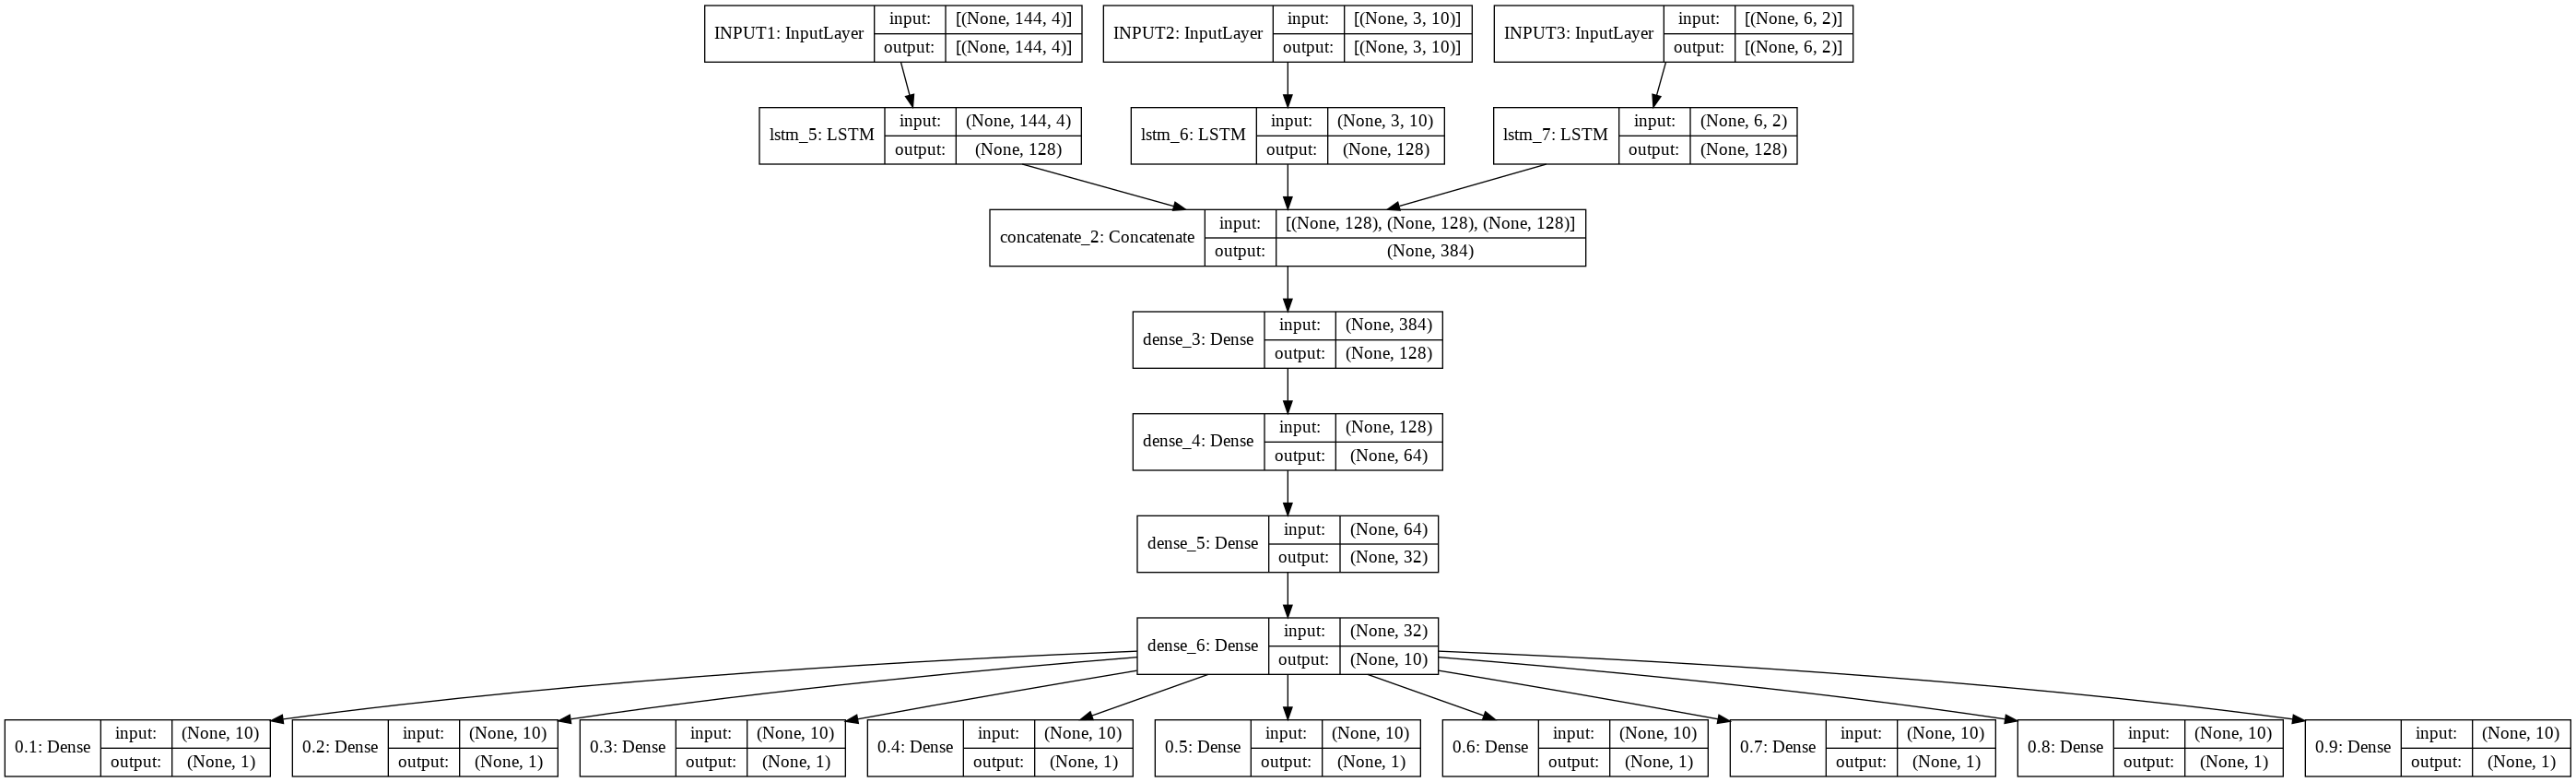

In [88]:
model = model_build()
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

In [ ]:
def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LSTM_actual_pred = pd.DataFrame()
    for q in quantiles:
      
      # model = Sequential()
      # model_input = keras.Input(shape=(trainset.shape[1], trainset.shape[2]), name='INPUT')
      # model_body = layers.LSTM(128, dropout = 0.3)(model_input)

      # x = layers.Dense(64, activation='relu')(model_body)
      # x = layers.Dense(32, activation='relu')(x)

      # output = layers.Dense(1, name = '0.1')(x)
      # model = Model(inputs=[model_input], outputs=[output])
      # model.compile(loss=lambda y,pred: quantile_loss(y,pred, q), optimizer='adam')

      history = model.fit(X_train, Y_train, epochs=10, batch_size=200, validation_data=(X_valid, Y_valid), shuffle=True, callbacks=[es, mc])
      pred = model.predict(X_test)
      pred = pred.reshape(pred.shape[0],1)
      # pred = scaler_y.inverse_transform(pred)
      pred = pd.DataFrame(pred)
      LSTM_actual_pred = pd.concat([LSTM_actual_pred,pred],axis=1)
        
    LSTM_actual_pred.columns=quantiles
    
    return LSTM_actual_pred

In [89]:
tock = time.time()

model1 = model_build()
model2 = model_build()
history1 = model1.fit([trainset1, trainset2, trainset3], Y_train1, epochs=1000, batch_size=200, validation_data=([validset1, validset2, validset3], Y_valid1), shuffle=True, callbacks=[es, mc])
history2 = model1.fit([trainset1, trainset2, trainset3], Y_train2, epochs=1000, batch_size=200, validation_data=([validset1, validset2, validset3], Y_valid2), shuffle=True, callbacks=[es, mc])

tick = time.time()

print('소요시간 :', tick-tock)

Epoch 1/1000
184/184 [==============================] - 19s 36ms/step - loss: 54.5309 - 0.1_loss: 2.3509 - 0.2_loss: 3.3422 - 0.3_loss: 6.7914 - 0.4_loss: 5.7602 - 0.5_loss: 6.4449 - 0.6_loss: 7.4306 - 0.7_loss: 7.3676 - 0.8_loss: 8.1173 - 0.9_loss: 6.9257 - val_loss: 23.4691 - val_0.1_loss: 1.5340 - val_0.2_loss: 2.5072 - val_0.3_loss: 3.2025 - val_0.4_loss: 3.3273 - val_0.5_loss: 3.2296 - val_0.6_loss: 3.1185 - val_0.7_loss: 2.8606 - val_0.8_loss: 2.2393 - val_0.9_loss: 1.4504
Epoch 2/1000
184/184 [==============================] - 5s 28ms/step - loss: 25.4519 - 0.1_loss: 1.5124 - 0.2_loss: 2.5546 - 0.3_loss: 3.1916 - 0.4_loss: 3.5133 - 0.5_loss: 3.6181 - 0.6_loss: 3.5165 - 0.7_loss: 3.1880 - 0.8_loss: 2.6114 - 0.9_loss: 1.7459 - val_loss: 25.0564 - val_0.1_loss: 1.5629 - val_0.2_loss: 2.7265 - val_0.3_loss: 3.2147 - val_0.4_loss: 3.4113 - val_0.5_loss: 3.6811 - val_0.6_loss: 3.3204 - val_0.7_loss: 3.1769 - val_0.8_loss: 2.3679 - val_0.9_loss: 1.5945
Epoch 3/1000
184/184 [===========

In [90]:
print('소요시간 :', tick-tock)

소요시간 : 1131.560194015503


In [92]:
pred1 = model1.predict([testset1, testset2, testset3])
pred2 = model2.predict([testset1, testset2, testset3])

results_1 = pd.DataFrame()
results_2 = pd.DataFrame()

for i in range(0, 9):
  temp = pd.DataFrame(pred1[i])
  results_1 = pd.concat([results_1, temp], axis = 1)

for i in range(0, 9):
  temp = pd.DataFrame(pred1[i])
  results_2 = pd.concat([results_2, temp], axis = 1)

In [93]:
results_2

,0,0,0,0,0,0,0,0,0
0,-0.000694,-0.001070,-0.000700,-0.000607,0.000968,0.000666,-0.000267,0.001627,0.001209
1,-0.000694,-0.001070,-0.000700,-0.000607,0.000968,0.000666,-0.000267,0.001627,0.001209
2,-0.011237,-0.004955,0.004543,-0.003584,0.002048,-0.002919,0.002071,0.003867,-0.000681
3,-0.000694,-0.001070,-0.000700,-0.000607,0.000968,0.000666,-0.000267,0.001627,0.001209
4,-0.000694,-0.001070,-0.000700,-0.000607,0.000968,0.000666,-0.000267,0.001627,0.001209
...,...,...,...,...,...,...,...,...,...
3883,-0.000694,-0.001070,-0.000700,-0.000607,0.000968,0.000666,-0.000267,0.001627,0.001209
3884,-0.000694,-0.001070,-0.000700,-0.000607,0.000968,0.000666,-0.000267,0.001627,0.001209
3885,-0.000694,-0.001070,-0.000700,-0.000607,0.000968,0.000666,-0.000267,0.001627,0.001209
3886,-0.000694,-0.001070,-0.000700,-0.000607,0.000968,0.000666,-0.000267,0.001627,0.001209


In [94]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission2 = submission.set_index('id')
submission3 = not_minus(submission2)

In [95]:
submission3

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
submission3.to_csv('submission_LSTM5.csv')
!cp submission_LSTM5.csv "drive/My Drive/"